# Interactive Map of Utah Firm Density #

For this project, I create an interactive geographic visualization of the number and type of firms in Utah by area code. 

To start, I import a bunch of different packages and specifiy the backend I want to use for matplotlib. 

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl
from matplotlib.colors import rgb2hex
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.basemap import Basemap

%matplotlib notebook



Next, I read in my data and do a little cleaning. The files "UtahFirms_SLC.csv" and "UtahFirms_Other.csv" have information on the name, address, zip code, phone number, number of employees, and North American Industry Classification System (NAICS) code of every firm in Utah. I got these files from the Utah Department of Workforce Services (https://jobs.utah.gov/jsp/firmfind/#/download). 

The file "NAICScodes.csv" contains a list of NAICS code ranges and their corresponding industry type. Every firm is given a code based on what type of industry it's classified under. For example, a clothing store would have an NAICS code that started with 44 since it falls under the "Retail Trade" categorization. 

In [80]:
# merge data on Salt Lake County firms and other Utah firms into single DataFrame
firms = pd.read_csv('UtahFirms_SLC.csv').append(pd.read_csv('UtahFirms_Other.csv'))

# read in data on NAICS codes 
NAICS = pd.read_csv('NAICScodes.csv')
NAICS['Number'] = NAICS['Number'].apply(str)
NAICS = NAICS.set_index('Number')

# give each firm an industry type based on its NAICS code
firms['Industry'] = firms.apply(lambda x: NAICS.loc[str(x['NAICS'])[0:2]], axis = 1)

# fix zipcodes
firms = firms.dropna(subset=['ZIP'])
firms['ZIP'] = firms.apply(lambda x: str(x['ZIP']).replace('.0','')[0:5],axis=1) 
firms = firms[(firms['ZIP'] != '1915') & (firms['ZIP'] != '54056') & (firms['ZIP'] != '62704') & (firms['ZIP'] != '97239')]


Now that I have my data, I can create my visualization. But first, I still need to import a shapefile that will allow me to draw the different area code regions in Utah. For this visualization, I use a shapefile that has the zip code tabulation areas (ZCTAs) for the United States (you can download it here: https://ceostroff.carto.com/tables/cb_2017_us_zcta510_500k/public/map). 

Using Basemap from the matplotlib toolkit library, you can read shapefiles and plot them (there is a good tutorial on this here: http://www.jtrive.com/visualizing-population-density-by-zip-code-with-basemap.html).

To start, I create a visualization of only the total number of firms in each area code region in Utah.

<IPython.core.display.Javascript object>


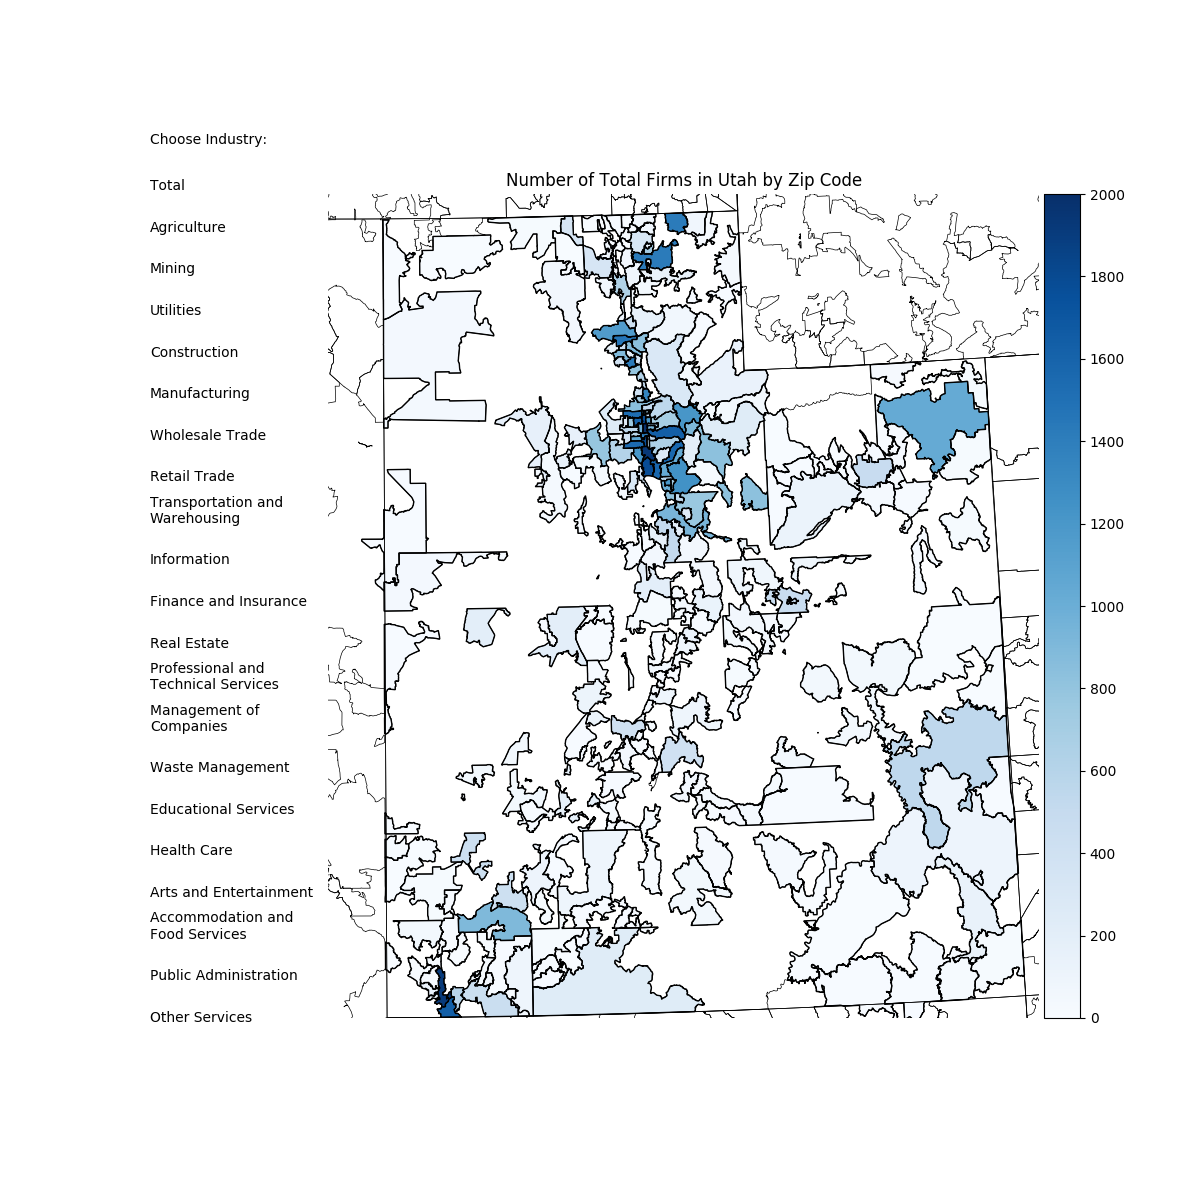

In [81]:
#name of all files in the shapefile folder
us_shape_file_dir = "cb_2017_us_zcta510_500k"

# Utah coordinates.
lowerlon = -114.5
upperlon = -108.5
lowerlat = 37
upperlat = 42

# Create figure
fig = plt.figure(figsize=(12, 12))

# Separate into two plots: small one on the left and larger one on the right
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 8])
    
# Larger subplot on right
ax1 = plt.subplot(gs[1])

# Basemap of Utah
m = Basemap(
    llcrnrlon=lowerlon,
    llcrnrlat=lowerlat,
    urcrnrlon=upperlon,
    urcrnrlat=upperlat,
    resolution='c',
    projection='lcc',
    lat_0=lowerlat,
    lat_1=upperlat,
    lon_0=lowerlon,
    lon_1=upperlon
    )
m.drawstates(color='black')
shp_info = m.readshapefile(us_shape_file_dir,'states',drawbounds=True)    
ax1.axis("off")

# Total number of firms in each zip code region 
numFirms = firms.groupby('ZIP')['NAME'].count()

# Create a dictionary of zip codes and total number of firms
firmDensity = {str(i):j for (i, j) in zip(numFirms.index.values,numFirms.values)}

# zip code information from shapefile
zip_info = m.states_info
state_info = enumerate(m.states)
ziplist = []
colors = {}

# min and max values for the colormap as well as the increment
vmin = 0.
vmax = 2000.
interval = 200

# colormap palate
colormap = plt.cm.Blues

# get a list of all the zip codes we'll use 
for d in zip_info:
    iterzip = d["zcta5ce10"]
    if iterzip in firmDensity.keys():
        iterFirms = firmDensity.get(iterzip,0)
        colors[iterzip] = colormap(iterFirms/vmax)[:3]
    ziplist.append(iterzip)

# fill the zip code regions with the color corresponding to the number of total firms in the area
for nshape,seg in state_info:
    i, j = zip(*seg)
    if ziplist[nshape] in firmDensity.keys():
        color = rgb2hex(colors[ziplist[nshape]])
        edgecolor = "#000000"
        ax1.fill(i,j,color,edgecolor=edgecolor);
        
# make a colorbar
sm = plt.cm.ScalarMappable(cmap=colormap,norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax))
mm = plt.cm.ScalarMappable(cmap=colormap)
mm.set_array([vmin, vmax])

# plot the colorbar to right of the graph
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
c = fig.colorbar(mm, ticks=np.arange(vmin, vmax+1, interval), cax=cax, orientation='vertical')

# give the figure a title and turn off the axes 
ax1.set_title('Number of Total Firms in Utah by Zip Code')
ax1.axis("off")

# smaller subplot on the left
ax2 = plt.subplot(gs[0])
ax2.axis("off")

# list of the different types of industries (according to NAICS classification)
industries = [
    'Agriculture','Mining','Utilities','Construction','Manufacturing',
    'Wholesale Trade','Retail Trade','Transportation and\nWarehousing','Information','Finance and Insurance',
    'Real Estate','Professional and\nTechnical Services',
    'Management of\nCompanies',
    'Waste Management',
    'Educational Services','Health Care','Arts and Entertainment',
    'Accommodation and\nFood Services','Public Administration','Other Services']

# Create list of the different types of industries to the left of the graph and set picker to True for each of them
ax2.annotate('Choose Industry:',xy=(0,1))
ax2.annotate('Total',xy=(0,.95), picker=5, label = 'Total')
for x in range(len(industries)):
    ax2.annotate(industries[x],xy=(0, .905 -.045*x), color='black', label=str(x), picker=True)
    

Now, I can add some interactivity to the visualization by making it so the user can pick which type of firm they want to look at. 

To do this, I first create a function called drawMap that redraws the graph using only the data from the specified industry type. This is similiar to the code above that I used to draw the graph for the total number of firms but I'm not going to read in the shapefile and draw the basemap again since it takes such a long time. Instead, since I already have the information on the zip code areas, I just redraw the new coloring. 

In [82]:
def drawMap(industry, vmax, interval, words):
'''
Takes in the industry type, the maximum value of the colorbar, 
and the words to be displayed in the title of the figure.
Redraws the figure using data on only the specified industry type. 
'''
    # clear the plot 
    ax1.cla()
    
    # manually redraw the statelines
    ax1.plot([40000,487000,458000,290000,285000,38000,40000], [0,16300,460000,450000,562000,557000,0], color='black',linewidth=.9)
    
    # if the user wants to go back to the total firms graph
    if industry == '':
        numFirms = firms.groupby('ZIP')['NAME'].count()
    # if the user selected a specific industry type
    else:
        # use only the data on the specified industry type
        numFirms = firms[firms['Industry']==industry].groupby('ZIP')['NAME'].count()
        
    # Create a dictionary of zip codes and total number of firms
    firmDensity = {str(i):j for (i, j) in zip(numFirms.index.values,numFirms.values)}

    # zip code information from shapefile
    zip_info = m.states_info
    state_info = enumerate(m.states)
    ziplist = []
    colors = {}
    vmin = 0.
    
    # colormap palate
    colormap = plt.cm.Blues

    # get a list of all the zip codes we'll use 
    for d in zip_info:
        iterzip = d["zcta5ce10"]
        if iterzip in firmDensity.keys():
            iterFirms = firmDensity.get(iterzip,0)
            colors[iterzip] = colormap(iterFirms/vmax)[:3]
        ziplist.append(iterzip)

    # fill the zip code regions with the color corresponding to the number of firms of the specified type in the area
    for nshape,seg in state_info:
        i, j = zip(*seg)
        if ziplist[nshape] in firmDensity.keys():
            color = rgb2hex(colors[ziplist[nshape]])
            edgecolor = "#000000"
            ax1.fill(i,j,color,edgecolor=edgecolor);

    # change the tick labels on the colorbar to reflect the new maximum value
    cax.set_yticklabels([x*vmax/10 for x in range(11)])   
    
    # Put the specified type of firm in the title and turn off the axes
    ax1.set_title('Number of ' +words+ ' Firms in Utah by Zip Code')
    ax1.axis("off")
    

Finally, I create an onpick() function that calls the drawMap() function whenever the user clicks on one of the industry choices. Each call to the drawMap() function uses parameters specific to the type of industry the user picked. 

In [83]:
def onpick(event):
'''
function to add interactivity to the figure
calls the drawMap function with parameters specific to the type of industry the user selected
'''
    # get the label of the annotation 
    artist = event.artist
    lab = artist.get_label()
    
    # redraw the figure witht he drawMap function according to which type of industry the user picked
    if lab == '0':
        drawMap('Agriculture, Forestry, Fishing and Hunting', 15., 3,'Agriculture')
    elif lab == '1':
        drawMap('Mining', 100., 20,'Mining')
    elif lab == '2':
        drawMap('Utilities', 10., 2,'Utilities')
    elif lab == '3':
        drawMap('Construction', 300., 50,'Construction')
    elif lab == '4':
        drawMap('Manufacturing', 250., 50,'Manufacturing')
    elif lab == '5':
        drawMap('Wholesale Trade', 300., 50,'Wholesale Trade')
    elif lab == '6':
        drawMap('Retail Trade', 250., 50,'Retail Trade')
    elif lab == '7':
        drawMap('Transportation and Warehousing', 150., 30,'Transportation and Warehousing')
    elif lab == '8':
        drawMap('Information', 50., 10,'Information')
    elif lab == '9':
        drawMap('Finance and Insurance', 200., 40,'Finance and Insurance')
    elif lab == '10':
        drawMap('Real Estate Rental and Leasing', 150., 30,'Real Estate')
    elif lab == '11':
        drawMap('Professional, Scientific, and Technical Services', 350., 50,'Professional and Technical Services')
    elif lab == '12':
        drawMap('Management of Companies and Enterprises', 25., 5,'Management')
    elif lab == '13':
        drawMap('Administrative and Support and Waste Management and Remediation Services', 100., 20, 'Waste Management')
    elif lab == '14':
        drawMap('Educational Services', 50., 10,'Educational Services')
    elif lab == '15':
        drawMap('Health Care and Social Assistance', 300., 50,'Health Care')
    elif lab == '16':
        drawMap('Arts, Entertainment, and Recreation', 30., 5,'Arts and Entertainment')
    elif lab == '17':
        drawMap('Accommodation and Food Services', 150., 30,'Accomodation and Food Services')
    elif lab == '19':
        drawMap('Other Services (except Public Administration)', 150., 30,'Other Services')
    elif lab == '18':
        drawMap('Public Administration', 50., 10,'Public Administration')
    else:
        drawMap('', 2000., 200,'Total')
    
plt.gcf().canvas.mpl_connect('pick_event', onpick)



6